In [1]:
import pandas as pd
import numpy as np


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import time

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset

In [5]:
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

In [6]:
import cv2
import os
from glob import glob
from tqdm import tqdm 
import shutil

In [7]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [9]:
# read img and mask
train_img_path = sorted(glob('/Users/hari/Downloads/Data/train/image/*.png'))
train_mask_path = sorted(glob('/Users/hari/Downloads/Data/train/mask/*.png'))
train_df = pd.DataFrame({"images":train_img_path,"mask":train_mask_path})
train_df.head()

,images,mask
0,/Users/hari/Downloads/Data/train/image/0.png,/Users/hari/Downloads/Data/train/mask/0.png
1,/Users/hari/Downloads/Data/train/image/1.png,/Users/hari/Downloads/Data/train/mask/1.png
2,/Users/hari/Downloads/Data/train/image/10.png,/Users/hari/Downloads/Data/train/mask/10.png
3,/Users/hari/Downloads/Data/train/image/11.png,/Users/hari/Downloads/Data/train/mask/11.png
4,/Users/hari/Downloads/Data/train/image/12.png,/Users/hari/Downloads/Data/train/mask/12.png


In [10]:
test_img_path = sorted(glob('/Users/hari/Downloads/Data/test/image/*.png'))
test_mask_path = sorted(glob('/Users/hari/Downloads/Data/test/mask/*.png'))
test_df = pd.DataFrame({"images":test_img_path,"mask":test_mask_path})
test_df.head()

,images,mask
0,/Users/hari/Downloads/Data/test/image/0.png,/Users/hari/Downloads/Data/test/mask/0.png
1,/Users/hari/Downloads/Data/test/image/1.png,/Users/hari/Downloads/Data/test/mask/1.png
2,/Users/hari/Downloads/Data/test/image/10.png,/Users/hari/Downloads/Data/test/mask/10.png
3,/Users/hari/Downloads/Data/test/image/11.png,/Users/hari/Downloads/Data/test/mask/11.png
4,/Users/hari/Downloads/Data/test/image/12.png,/Users/hari/Downloads/Data/test/mask/12.png


# Show Images

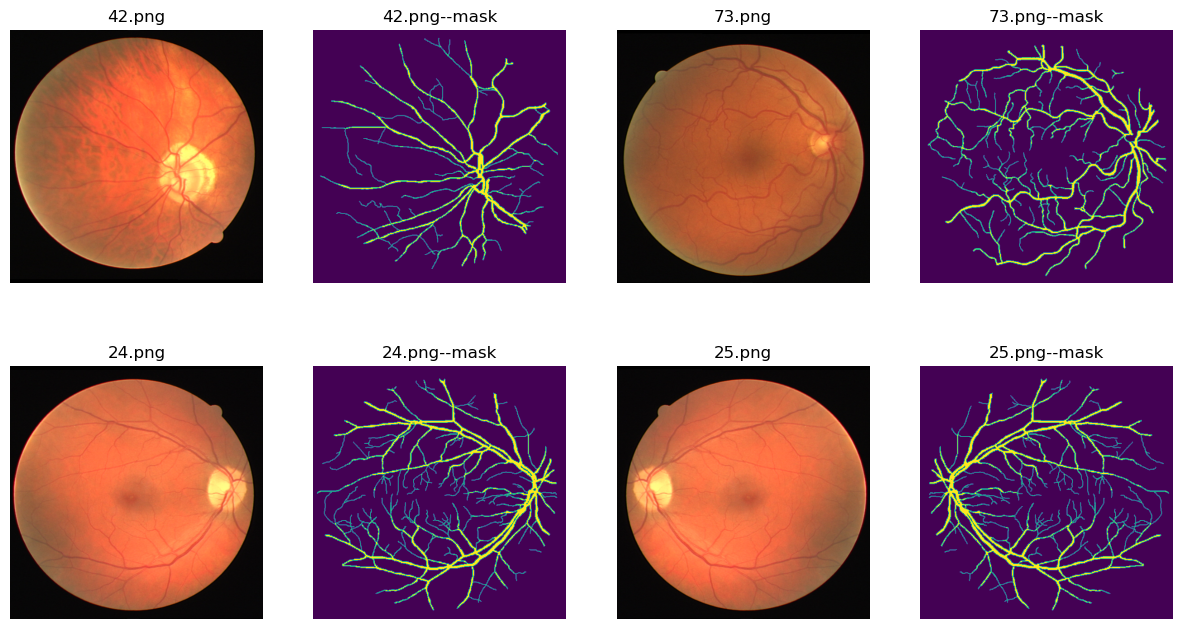

In [11]:
show_img = 4
idx = np.random.choice(len(train_df),show_img,replace = False)
fig, axes = plt.subplots(show_img*2//4,4,figsize = (15,8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i%2==0:
        full_path = train_df.loc[idx[new_i]]['images']
        basename = os.path.basename(full_path)
    else:
        full_path = train_df.loc[idx[new_i]]['mask']
        basename = os.path.basename(full_path)+ '--mask'
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

# Load Datasets and DataLoaders

In [12]:
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
])

In [13]:
test_transforms = A.Compose([A.Resize(512,512),])

In [14]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,dataframe,transforms_=None):
        self.df = dataframe
        self.transforms = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485,0.456,0.506],std = [0.229,0.224,0.225]),])
        self.resize = [512,512]
        self.class_size = 2
    def __len__ (self):
        return len(self.df)
    def __getitem__(self,index):
        img = cv2.imread(self.df.iloc[index]['mask'],cv2.IMREAD_GRAYSCALE)
        mask = np.where (mask<127,0,1).astype(np.int16)
        aug = self.transforms_(images=img,mask=mask)
        img, mask = auf['image'], aug['mask']
        img = img/255
        img = torch.tensor(img, dtype= torch.float).permute(2,0,1)
        target = torch.tensor(mask,dtype = torch.long)
        sample = {'x':img, 'y':target}
        return sample

In [15]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_dataset = MyDataset(train_df,train_transforms)
val_dataset = MyDataset(test_df,test_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size= BATCH_SIZE,shuffle= True)
print(f'len Train:{len(train_df)}')
print(f'len Val:{len(test_df)}')

len Train:80
len Val:20
